In [1]:
import re
import sys
import os
import glob

from collections import Counter
from quantities import units
from quantities.units.area import D
from quantities.unitquantity import UnitQuantity as UQ

import scipy
import pandas as pd
import spacy
import sklearn_crfsuite
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

# %matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
tags = {'QUANT' : 'Quantity'}
lang_model = spacy.load('en_core_web_sm')

In [3]:
units_list = []

train_raw_files = glob.glob("train/text/*.txt")
train_tsv_files = glob.glob("train/tsv/*.tsv")
test_raw_files = glob.glob("trial/txt/*.txt")
test_tsv_files = glob.glob("trial/tsv/*.tsv")
eval_raw_files = glob.glob("eval/text/*.txt")

In [4]:
def raw_text_to_df(raw_files):
    """converting raw training files to dataframes"""
    # dict to be exported as dataframe
    documents_of_interest = {
        'document_name': [],
        'sentence': [],
        'entities': [],
        'np': []
    }
    # filling the dict
    for raw_file in raw_files:
        with open(raw_file, "r") as file:
            # print(file.name.split('/')[2])
            doc_name = file.name.split("/")[2]
            doc_name = doc_name.split('.')[0]
            file_content = lang_model(file.read())
            for sentence in file_content.sents:
                sentence_pos_tags = [word.tag_ for word in sentence]
                documents_of_interest['document_name'].append(doc_name)
                documents_of_interest['sentence'].append(sentence)
                entities = []
                for measurement in sentence.ents:
                    entities.append((measurement.label_,(measurement.start, measurement.end)))
                documents_of_interest['entities'].append(
                    entities
                )

                noun_phrases = []

                for chunk in sentence.noun_chunks:
                    noun_phrases.append((chunk.text, (chunk.start, chunk.end)))
                documents_of_interest['np'].append(noun_phrases)
                    
        # break
    dataframe = pd.DataFrame(
        documents_of_interest,
        columns=['document_name', 'sentence', 'entities', 'np'],
    )
    return dataframe

In [5]:
def get_text_labels(text_dataframe, tsv_dataframe):
    labels = []
    for _, text_row in text_dataframe.iterrows():
        sentence_tag_placeholders = []
        for word in text_row['sentence']:
            sentence_tag_placeholders.append(
                ['O', (word.idx, (word.idx + len(word)))]
            )
        # O means not a quantity QUANT means quantity
        document_name = text_row['document_name']
#         print(document_name)
        doc_id = tsv_dataframe['docId'] == document_name
        for _, annot_row in tsv_dataframe[doc_id].iterrows():
            annotType = annot_row['annotType']
            if annotType == 'Qualifier':
                continue
            
            if annotType == 'Quantity':
                annotType = 'QUANT'
            else :
                annotType = 'O'

            for i, item in enumerate(sentence_tag_placeholders):
                if item[0] != 'O':
                    continue
                
                if (annot_row['startOffset'] <= item[1][0] < annot_row['endOffset']) or (annot_row['startOffset'] < item[1][1] <= annot_row['endOffset']):
                    if annotType != 'O':
                        sentence_tag_placeholders[i][0] = annotType
        

        labels.append([label for label, _ in sentence_tag_placeholders])
                
    return labels

In [6]:
def get_units() :
    units_list = ['%'] # Add possible unit symbols
    for key, value in units.__dict__.items():
        if isinstance(value, UQ):
            if key not in units_list :
                units_list.append(key.lower())
            if value.name not in units_list :
                units_list.append(value.name.lower())
        
    return units_list

In [7]:
def is_unit(token):
    return token.lower_ in units_list or token.lemma_ in units_list

In [8]:
def features_word(word, entities, nouns, length, pos):
    
    features = {
        'bias': 1.0,
        'lemma': word.lemma_,
        'upper': word.is_upper,
        'title': word.is_title,
        'digit': word.is_digit,
        'numlike': word.like_num,
        'unit': is_unit(word),
        'postag': word.tag_,
        'dep': word.dep_
    }
    
    for entity in entities:
        if entity[1][0] <= word.i < entity[1][1]:
            features['entity'] = entity[0]
            break
    
    for noun in nouns:
        if noun[1][0] <= word.i < noun[1][1]:
            features['np'] = list(noun[0])
            break
    
    if pos >= 1 :
        new_word = word.nbor(-1)
        features.update({
            '-lemma': new_word.lemma_,
            '-upper': new_word.is_upper,
            '-title': new_word.is_title,
            '-digit': new_word.is_digit,
            '-numlike': new_word.like_num,
            '-unit': is_unit(new_word),
            '-postag': new_word.tag_,
            '-dep': new_word.dep_
        })
        
        
    if pos <= length-2 :
        new_word = word.nbor(1)
        features.update({
            '+lemma': new_word.lemma_,
            '+upper': new_word.is_upper,
            '+title': new_word.is_title,
            '+digit': new_word.is_digit,
            '+numlike': new_word.like_num,
            '+unit': is_unit(new_word),
            '+postag': new_word.tag_,
            '+dep': new_word.dep_
        })
    
    return features

In [9]:
def features_sentence(sentence, entities, nouns):
    sentence_features = []
    for i in range(0, len(sentence)) :
        word_features = features_word(sentence[i], entities, nouns, len(sentence), i)
        sentence_features.append(word_features)
    return sentence_features

In [10]:
def write_predictions_to_tsv(text_dataframe, y_pred, dirname):
    tsv_columns = [
        "docId",
        "annotSet",
        "annotType",
        "startOffset",
        "endOffset",
        "annotId",
        "text",
        "other"
    ]
    # save the results in appropriate format in a new dataframe
    row_id = 0
    output_list = []
    prev_file = ""
    annot_set_index = 1
    annot_index = 1
    for i, text_row in text_dataframe.iterrows():
        file_name = text_row['document_name']
        if i > 0 and file_name != prev_file:
            result_df = pd.DataFrame(output_list, columns=tsv_columns)
            result_df.to_csv(dirname + prev_file + '.tsv', sep="\t", index=False)
            output_list = []
            annot_set_index = 1
            annot_index = 1

        pred_pos = y_pred[row_id]
        row_id += 1
        sentence = text_row['sentence']
        word_ind = 0
        
        while word_ind < len(pred_pos) :
            if pred_pos[word_ind] == 'O':
                word_ind += 1
                continue
            
            start_ind = word_ind
            while word_ind < len(pred_pos) and pred_pos[word_ind] == 'QUANT':
                word_ind += 1
            end_ind = word_ind - 1
            
            quant_text = sentence.doc[sentence[start_ind].i : sentence[end_ind].i + 1]
            
            output_list.append([file_name, annot_set_index, tags['QUANT'], sentence[start_ind].idx, sentence[end_ind].idx + len(sentence[end_ind]), annot_index, quant_text, ""])
            annot_set_index += 1
            annot_index += 1
        
        prev_file = file_name
        
    result_df = pd.DataFrame(output_list, columns=tsv_columns)
    result_df.to_csv(dirname + prev_file + '.tsv', sep="\t", index=False)
    return

In [11]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

In [12]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [13]:
units_list = get_units()

train_text_dataframe = raw_text_to_df(train_raw_files)
# train_text_dataframe.to_csv("./CSV/train_text_dataframe.csv")

each_file_df = []
for tsv_file in train_tsv_files:
    each_file_df.append(pd.read_csv(tsv_file, sep="\t", header=0))

train_tsv_dataframe = pd.concat(each_file_df)
# train_tsv_dataframe.to_csv("./CSV/train_tsv_dataframe.csv")

test_text_dataframe = raw_text_to_df(test_raw_files)
# test_text_dataframe.to_csv("./CSV/test_text_dataframe.csv")

each_file_test = []
for tsv_file in test_tsv_files:
    each_file_test.append(pd.read_csv(tsv_file, sep="\t", header=0))

test_tsv_dataframe = pd.concat(each_file_test)
# test_tsv_dataframe.to_csv("./CSV/test_tsv_dataframe.csv")

In [14]:
X_train = []
for _, row in train_text_dataframe.iterrows() :
    features = features_sentence(row['sentence'], row['entities'], row['np'])
    X_train.append(features)

y_train = get_text_labels(train_text_dataframe, train_tsv_dataframe)

In [15]:
X_test = []
for _, row in test_text_dataframe.iterrows() :
    features = features_sentence(row['sentence'], row['entities'], row['np'])
    X_test.append(features)

y_test = get_text_labels(test_text_dataframe, test_tsv_dataframe)

In [16]:
X_train = X_train + X_test
y_train = y_train + y_test

In [17]:
eval_text_dataframe = raw_text_to_df(eval_raw_files)
X_eval = []
for _, row in eval_text_dataframe.iterrows() :
    features = features_sentence(row['sentence'], row['entities'], row['np'])
    X_eval.append(features)

In [18]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [19]:
labels = list(crf.classes_)
labels.remove('O')

In [20]:
y_pred = crf.predict(X_eval)

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [21]:
# if not os.path.exists('results_task1'):
#     os.makedirs('results_task1')
# write_predictions_to_tsv(eval_text_dataframe, y_pred, 'results_task1/')

In [22]:
# Training the model for hyperparameter search

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.5), 
}

f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.2min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f111aa66f10>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f111aa1b1d0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['QUANT']),
                   verbose=1)

In [23]:
crf = rs.best_estimator_
y_pred = crf.predict(X_eval)

In [24]:
if not os.path.exists('results_task1'):
    os.makedirs('results_task1')
write_predictions_to_tsv(eval_text_dataframe, y_pred, 'results_task1/')
print('Output written to results_task1 folder')

Output written to results_task1 folder


In [25]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.5305002583063962, 'c2': 0.016475812542654716}
best CV score: 0.84268392490035
model size: 0.09M


In [27]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(2))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-2:])

Top likely transitions:
O      -> O       1.292502
QUANT  -> QUANT   1.084034

Top unlikely transitions:
O      -> QUANT   -0.998955
QUANT  -> O       -2.660394


In [28]:
print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive features:
7.918259 O        lemma:=
5.896386 QUANT    -lemma:n.s
5.784479 O        lemma:cycle
5.597411 QUANT    lemma:ppm
5.520641 QUANT    lemma:∼0.8
5.420422 QUANT    lemma:∼10ev
5.179166 QUANT    -lemma:wt
5.092784 QUANT    lemma:wt.%
4.943498 QUANT    lemma:ratio=1.37
4.746920 QUANT    lemma:s−1

Top negative features:
-2.080160 O        +lemma:central
-2.112783 O        -lemma:w
-2.113388 O        +lemma:DC
-2.153016 O        -lemma:p
-2.240527 O        np:≥
-2.380385 O        -lemma:ca
-2.697614 O        +lemma:2sd
-2.703891 O        lemma:none
-2.811366 QUANT    lemma:at
-3.296493 O        -lemma:room


Dark blue => 0.8025, dark red => 0.8427


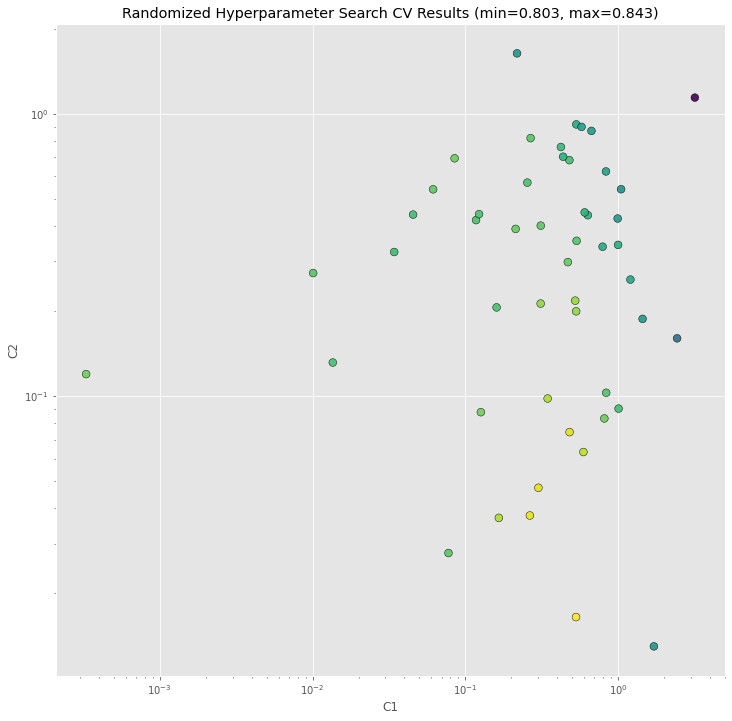

In [29]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))